In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation 
from nerfstudio.utils.eval_utils import eval_setup
from inerf.inerf_trainer import load_data_into_trainer
from inerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image, transform_original_space_to_pose

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
os.chdir('/workspace')
MODEL_PATH = "/workspace/outputs/jackal_with_box/plane-nerf/2024-02-13_150433"
DATA_PATH = "/stored_data/jackal_one_frame_box"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "ground_truth.json")
TRANSFORM_FILE = "transforms.json"
with open(GROUND_TRUTH_PATH) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [4]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 // 2

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)

trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 10
trainer.pipeline.datamanager.METHOD = "sift"
trainer.pipeline.datamanager.get_inerf_batch()  

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

/workspace/inerf/inerf/inerf_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  camera_to_worlds = torch.cat([camera_to_worlds, tensor([tf]).float()], 0)


Setting up training dataset...

Caching all 1 images.

Output()

Loading PlaneNerfCameraOptimizer


[17:25:14] Saving checkpoints to: outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models  ]8;id=630638;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=829253;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#134\134]8;;\

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_with_box/plane-nerf/2024-02-13_150433/nerfstudio_models/step-000009999.ckpt

Number of keypoints:  62
Number of rays:  2987
Reduce the number of rays
Final number of rays:  2048


In [5]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

In [6]:
corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))

#Correct Translation_error
for i in range(100):
    loss = trainer.train_iteration_inerf(0,optimizer_lr = 1e-3)

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
print(loss)
    

Average translation error:  tensor(0.1000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1745, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average translation error:  tensor(0.0434, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1638, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0794, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1294], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 745}


In [35]:
corrected_pose_in_trainer = ground_truth_poses_in_trainer = transform_original_space_to_pose(corrected_pose.to("cpu").float(), 
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform,
                                                                trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
                                                                "opengl").detach()
print(corrected_pose_in_trainer)
store = []
for theta in range(-45,45,3):
    rotation = Rotation.from_euler('z', theta, degrees=True)
    rotation = rotation.as_matrix()
    rotation = torch.tensor(rotation).unsqueeze(0).float()
    
    new_pose = rotation @ corrected_pose_in_trainer
    trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = new_pose.to("cpu")
    pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
    pipeline.datamanager.setup_train()
    loss = trainer.get_loss()

    corrected_pose = get_corrected_pose(trainer)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)

    store.append([theta,float(loss["rgb_loss"]),loss["close_pixels"]])

tensor([[[ 0.9941,  0.0597, -0.0901, -0.1467],
         [-0.1059,  0.7053, -0.7010, -0.8995],
         [ 0.0217,  0.7064,  0.7075,  0.0000]]])


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2054, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1186, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1686], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 475}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1530, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1122, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1622], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 529}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1007, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1017, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1517], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 582}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.0483, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0950, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1450], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 671}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.0041, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0876, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1376], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 729}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.0564, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0771, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1271], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 785}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1088, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0736, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1236], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 818}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1611, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.0889, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1389], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 636}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2135, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1030, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1530], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 442}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.2659, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1124, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1624], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 356}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3182, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1227, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1727], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 295}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.3706, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1280, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1780], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 262}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.4229, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1297, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1797], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 242}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.4753, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1307, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1807], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 218}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5277, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1312, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1812], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 211}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.5800, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1300, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1800], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 201}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6324, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1315, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1815], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 213}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.6847, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1330, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1830], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 211}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.7371, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1356, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1856], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 246}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.7895, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1360, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1860], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 235}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.8418, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1354, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1854], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 247}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.8942, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1383, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1883], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 234}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.9465, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1423, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1923], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 209}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.9989, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1439, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1939], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 198}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.0513, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1449, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1949], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 200}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.1036, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1420, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1920], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 220}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.1560, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1374, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1874], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 228}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.2083, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1377, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1877], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 244}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.2607, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1413, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1913], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 224}


Setting up training dataset...

Caching all 1 images.

Output()

Average translation error:  tensor(0.0247, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(1.3131, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
{'rgb_loss': tensor(0.1470, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>), 'pixel_loss': tensor([0.0500], device='cuda:0', grad_fn=<MulBackward0>), 'loss': tensor([0.1970], device='cuda:0', grad_fn=<AddBackward0>), 'close_pixels': 187}


In [36]:
#Get index of smallest rgb loss
store = np.array(store)
index = np.argmin(store[:,1])
print(store[index])
print("Best rotation: ", store[index,0])
rotation = Rotation.from_euler('z', store[index,0], degrees=True)
rotation = rotation.as_matrix()
rotation = torch.tensor(rotation).unsqueeze(0).float()
new_pose = rotation @ corrected_pose_in_trainer

trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds = new_pose.to("cpu")
trainer.pipeline.datamanager.train_dataset = pipeline.datamanager.create_train_dataset()
trainer.pipeline.model.camera_optimizer.pose_adjustment = torch.nn.Parameter(torch.zeros((1, 3), device=trainer.pipeline.device))
trainer.pipeline.datamanager.setup_train()

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))

for i in range(10):
    for j in range(10):
        loss = trainer.train_iteration_inerf(0,optimizer_lr = 1e-3)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)
    

[-2.70000000e+01  7.36441599e-02  8.18000000e+02]
Best rotation:  -27.0


Setting up training dataset...

Caching all 1 images.

Output()

AssertionError: No inf checks were recorded prior to update.

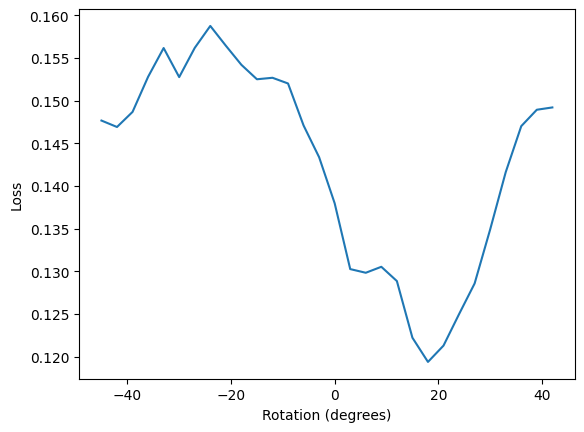

In [20]:
#Plot theta against results
store = np.array(store)
plt.plot(store[:,0],store[:,1])
plt.xlabel("Rotation (degrees)")
plt.ylabel("Loss")
plt.show()

In [ ]:
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
rendered_img = get_image(trainer.pipeline, corrected_pose[0:,:,:])
rendered_img = rendered_img["rgb"]

Text(0.5, 1.0, 'Rendered image')

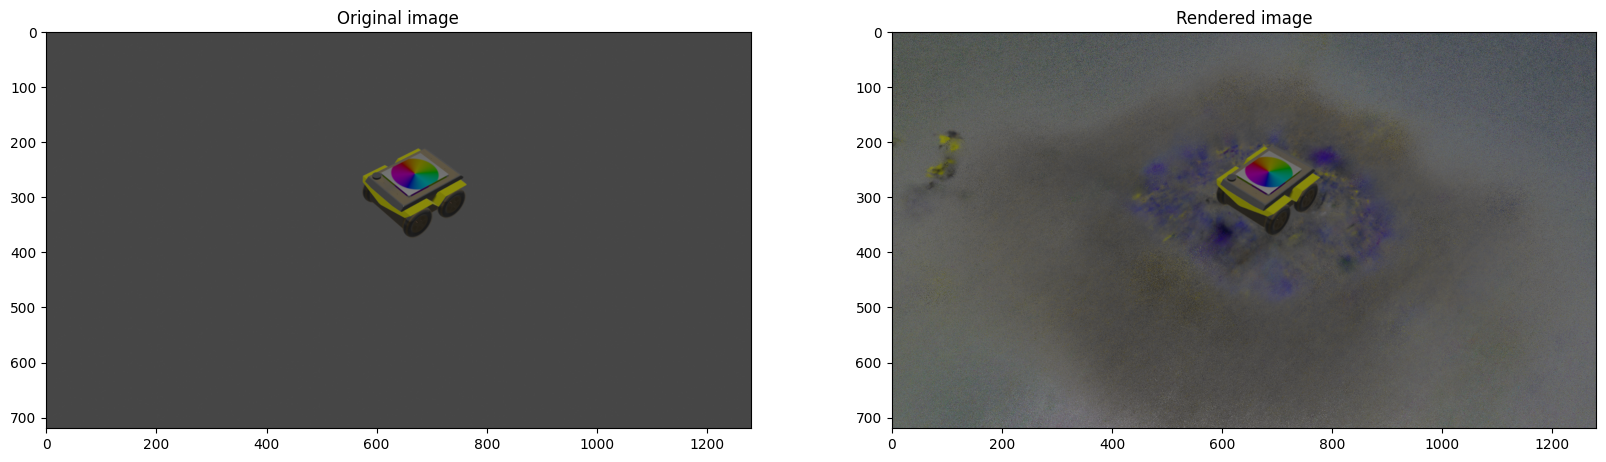

In [ ]:
#Plot original image and rendered image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(original_img)
ax[0].set_title("Original image")
ax[1].imshow(rendered_img)
ax[1].set_title("Rendered image")

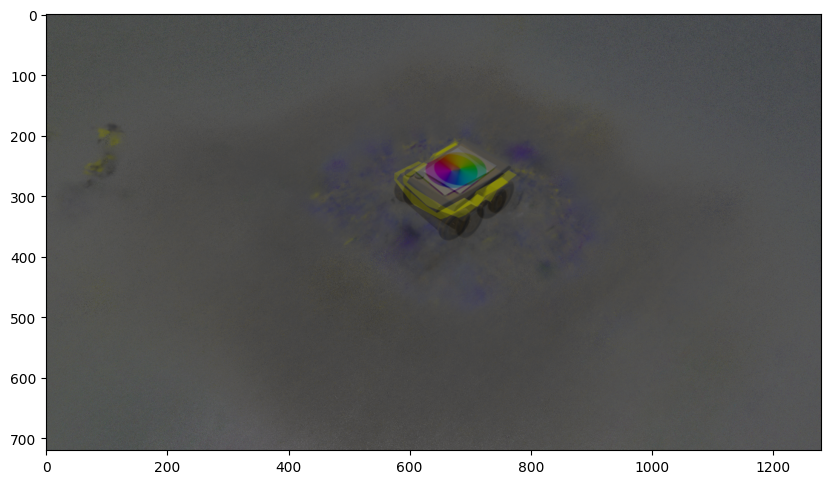

In [ ]:
#Overlay original image and rendered image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(original_img)
ax.imshow(rendered_img, alpha=0.5)


In [ ]:
batch = trainer.pipeline.datamanager.inerf_batch
ray_bundle = trainer.pipeline.datamanager.train_ray_generator(batch["indices"])

#Create blank 2D array
image = np.zeros((720, 1280, 3), dtype=np.float32)
cnt = np.zeros((720, 1280, 1), dtype=np.float32)

for i in range(len(batch['image'])):
    x,y = batch['indices'][i,1:]
    cnt[x,y] += 1
    image[x,y] = batch['image'][i,:3]

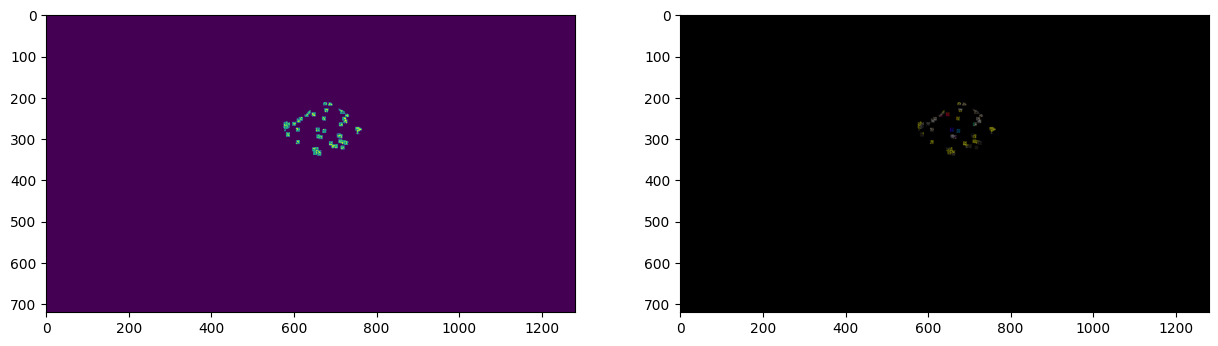

In [ ]:
# Plot cnt and image in subplot
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(cnt)
ax[1].imshow(image)
plt.show()